In [8]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras._tf_keras.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from keras._tf_keras.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras._tf_keras.keras import regularizers

In [9]:
np.random.seed(42)
DATADIR = r'./ck'
CATEGORIES = os.listdir(DATADIR)
CATEGORIES

['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

In [10]:
def load_data():
    DATADIR = r'./ck'
    data = []
    # loading training data
    for category in CATEGORIES:
        # create path to image of respective expression
        path = os.path.join(DATADIR, category)
        # get the classification  for each expression 
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), 0)
            data.append([img_array, class_num])
            
    return data
data = load_data()

100%|██████████| 249/249 [00:00<00:00, 3618.37it/s]


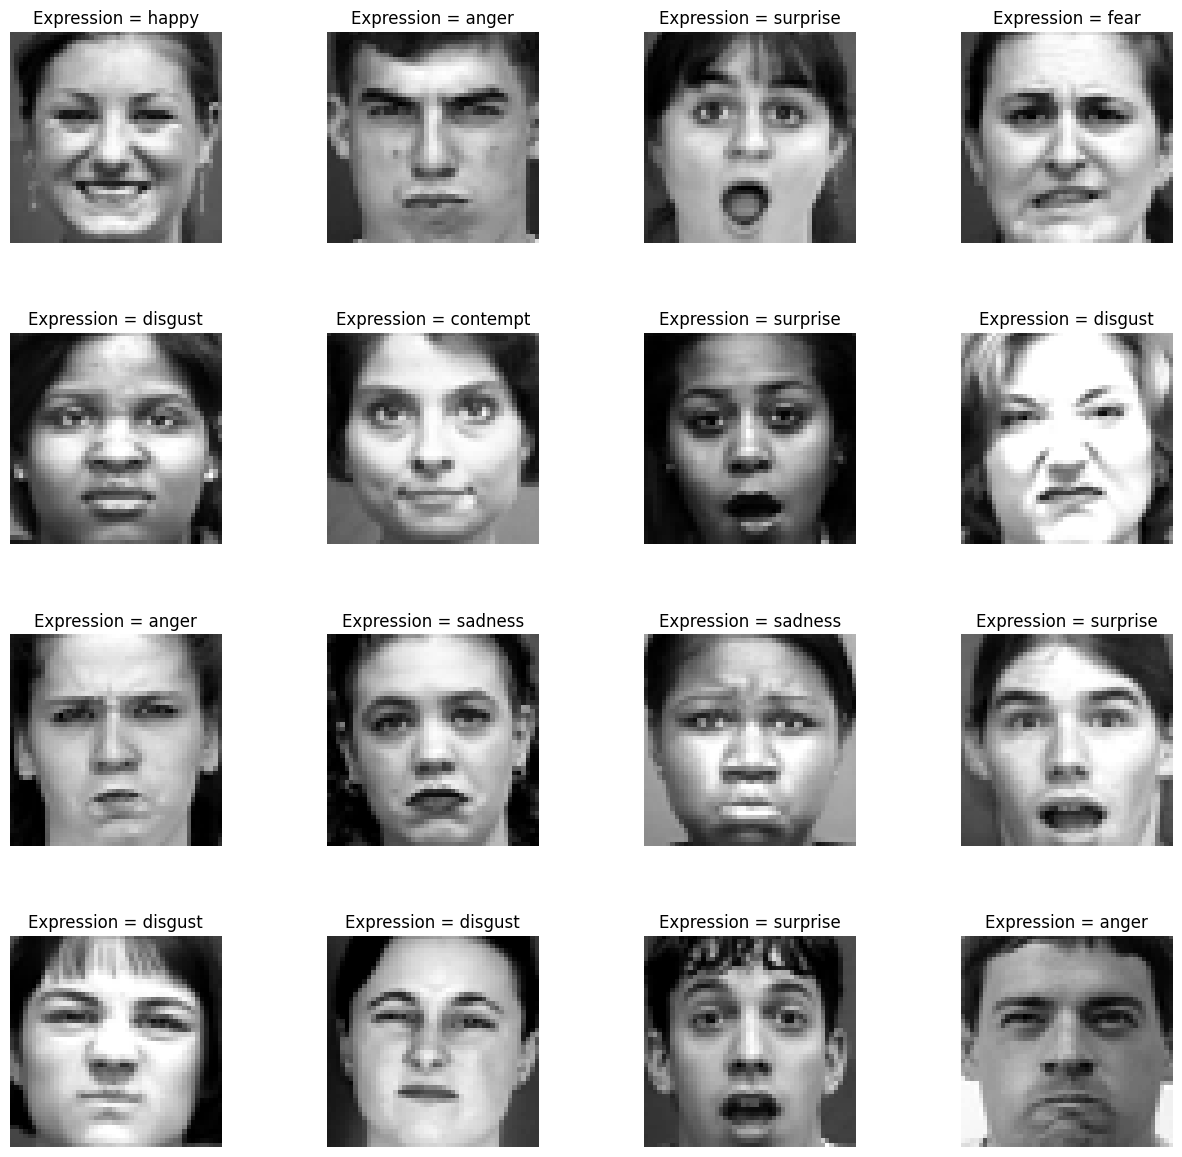

In [11]:
L = 4
W = 4
fig, axes = plt.subplots(L, W, figsize = (15,15))
axes = axes.ravel()

for i in range(0, L * W):  
    sample = random.choice(data)
    axes[i].set_title("Expression = "+str(CATEGORIES[sample[1]]))
    axes[i].imshow(sample[0], cmap='gray')
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [12]:
X = np.array([x[0] for x in data])
y = np.array([Y[1] for Y in data])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [14]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("-------------------------------")
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (784, 48, 48)
y_train shape:  (784,)
-------------------------------
X_test shape:  (197, 48, 48)
y_test shape:  (197,)


In [15]:
# reshaping y_train and y_test
y_train = np.reshape(y_train, (len(y_train),1))
y_test  = np.reshape(y_test , (len(y_test ),1))

print("After reshaping")
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

After reshaping
y_train shape:  (784, 1)
y_test shape:  (197, 1)


In [16]:
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print("After adding color channel")
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

After adding color channel
X_train shape:  (784, 48, 48, 1)
X_test shape:  (197, 48, 48, 1)


In [17]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [18]:
y_train[0]

array([6])

In [19]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [20]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1.])

In [21]:
y_train.shape, y_test.shape

((784, 7), (197, 7))

In [22]:
def Binarypattern(im):                               # creating function to get local binary pattern
    img= np.zeros_like(im)
    n=3                                              # taking kernel of size 3*3
    for i in range(0,im.shape[0]-n):                 # for image height
        for j in range(0,im.shape[1]-n):               # for image width
            x  = im[i:i+n,j:j+n]                     # reading the entire image in 3*3 format
            center       = x[1,1]                    # taking the center value for 3*3 kernel
            img1        = (x >= center)*1.0          # checking if neighbouring values of center value is greater or less than center value
            img1_vector = img1.T.flatten()           # getting the image pixel values 
            img1_vector = np.delete(img1_vector,4)  
            digit = np.where(img1_vector)[0]         
            if len(digit) >= 1:                     # converting the neighbouring pixels according to center pixel value
                num = np.sum(2**digit)              # if n> center assign 1 and if n<center assign 0
            else:                                    # if 1 then multiply by 2^digit and if 0 then making value 0 and aggregating all the values of kernel to get new center value
                num = 0
            img[i+1,j+1] = num
    return(img)

(-0.5, 47.5, 47.5, -0.5)

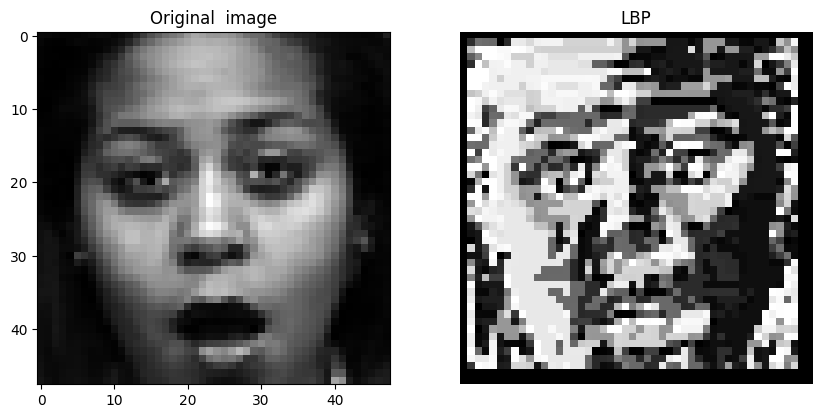

In [23]:
plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
img = random.choice(X_train)
plt.title("Original  image")
plt.imshow(img, cmap='gray')

plt.subplot(1,2,2)
plt.title("LBP")
imgLBP=Binarypattern(img)             # calling the LBP function using gray image
plt.imshow(imgLBP, cmap='gray')
plt.axis('off')

In [24]:
X_train.shape

(784, 48, 48, 1)

In [25]:
def create_LBP_features(data):
    Feature_data = np.zeros(data.shape)

    for i in range(len(data)):
        img = data[i]
        imgLBP=Binarypattern(img)  
        Feature_data[i] = imgLBP
    
    return Feature_data

In [26]:
Feature_X_train = create_LBP_features(X_train)

In [27]:
Feature_X_train.shape

(784, 48, 48, 1)

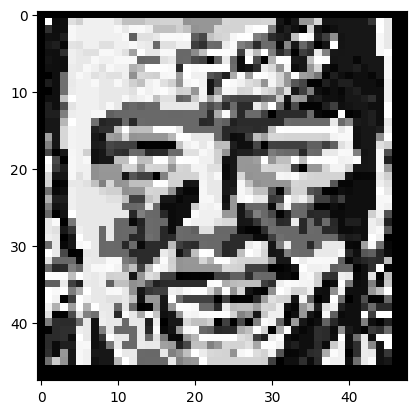

In [28]:
img = random.choice(Feature_X_train)
plt.imshow(img, cmap='gray')

In [29]:
Feature_X_test = create_LBP_features(X_test)
Feature_X_test.shape

(197, 48, 48, 1)

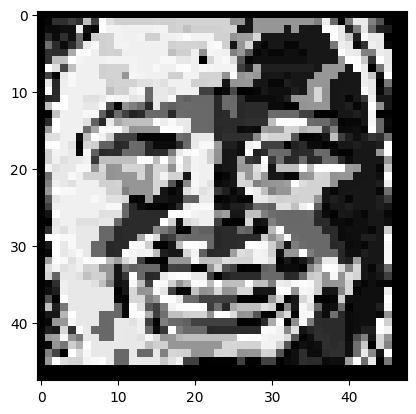

In [30]:
img = random.choice(Feature_X_test)
plt.imshow(img, cmap='gray')

In [31]:
def create_model(input_shape=None):
    if input_shape is None :
        input_shape=(48,48,1)

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))
    
    return model 

es = EarlyStopping(
    monitor='val_accuracy', min_delta=0.000001, patience=10, verbose=2,
    mode='max', baseline=None, restore_best_weights=True
)
lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=2,
    mode='max', min_delta=1e-5, cooldown=0, min_lr=0
)

callbacks = [es, lr]

In [32]:
LBP_model = create_model()
LBP_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
LBP_history = LBP_model.fit(Feature_X_train, y_train, batch_size=8 , epochs=50, validation_data = (Feature_X_test, y_test) ,callbacks = [callbacks])

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.1963 - loss: 13.6455 - val_accuracy: 0.3706 - val_loss: 1.6364 - learning_rate: 0.0010
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3468 - loss: 1.6906 - val_accuracy: 0.5482 - val_loss: 1.3590 - learning_rate: 0.0010
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5219 - loss: 1.3568 - val_accuracy: 0.6244 - val_loss: 1.0114 - learning_rate: 0.0010
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6050 - loss: 1.0655 - val_accuracy: 0.7107 - val_loss: 0.8450 - learning_rate: 0.0010
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6992 - loss: 0.8007 - val_accuracy: 0.7614 - val_loss: 0.7296 - learning_rate: 0.0010
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7676 - loss: 0.6671 - val_accuracy: 0.8274 - val_loss: 0.5022 - learning_rate: 0.0010
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8031 - loss: 0.5753 - val_accur

In [34]:
def plot_performance(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val loss evolution')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val accuracy')

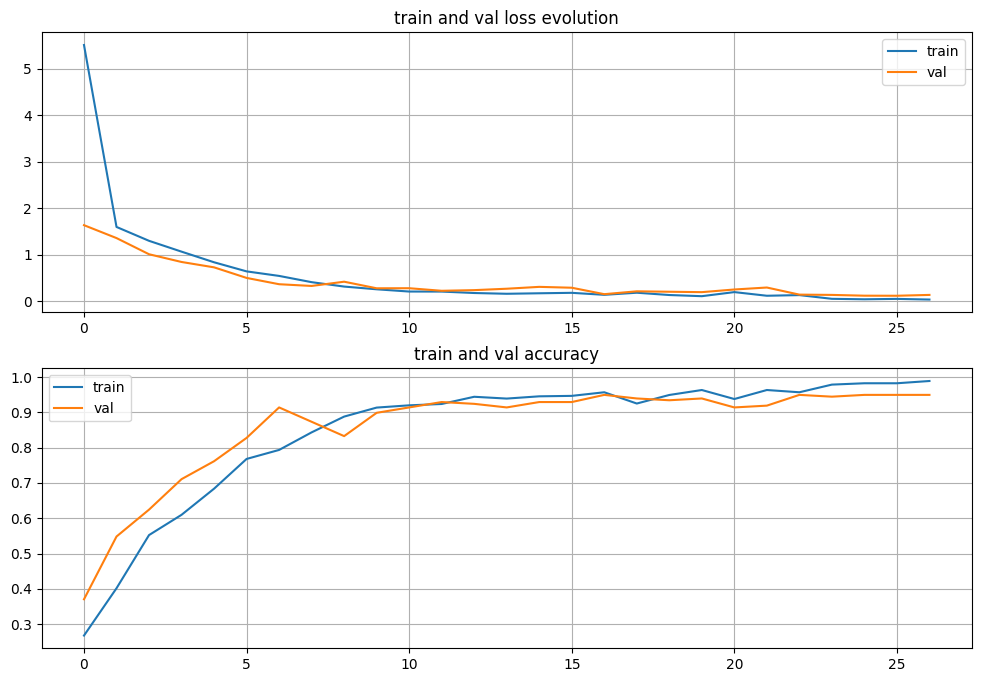

In [35]:
plot_performance(LBP_history)

In [36]:
LBP_acc = LBP_model.evaluate(Feature_X_test, y_test, verbose = 0)[1]
print("LBP Accuracy :",LBP_model.evaluate(Feature_X_test, y_test, verbose = 0)[1])

LBP Accuracy : 0.9492385983467102


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


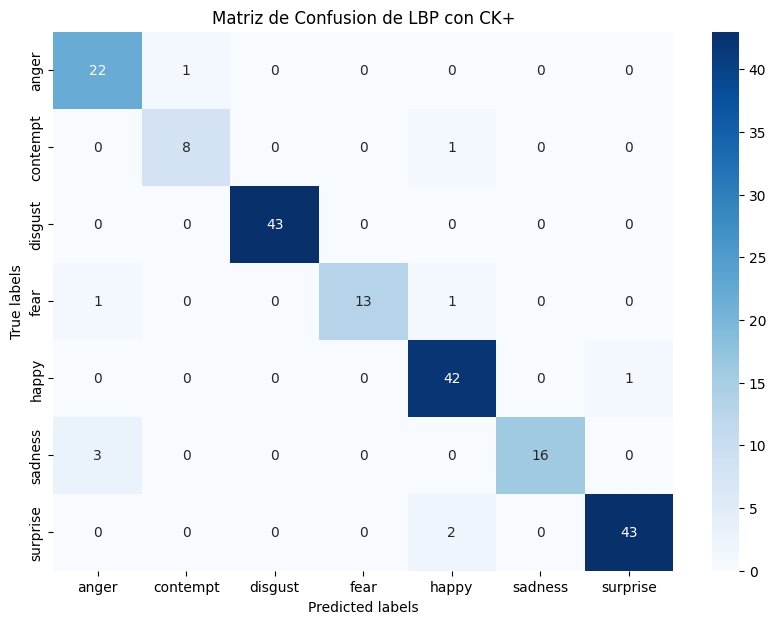

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Calcula la matriz de confusión y el reporte de clasificación
y_pred = np.argmax(LBP_model.predict(Feature_X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)
conf_mat = confusion_matrix(y_true, y_pred)

# Crea un mapa de calor usando seaborn
plt.figure(figsize=(10, 7)) # Ajusta el tamaño de la figura
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)

# Añade títulos y etiquetas
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Matriz de Confusion de LBP con CK+')
plt.show()

In [54]:
class_report = classification_report(y_true, y_pred, target_names=CATEGORIES)
print("\nClassification Report:\n", class_report)



Classification Report:
               precision    recall  f1-score   support

       anger       0.85      0.96      0.90        23
    contempt       0.89      0.89      0.89         9
     disgust       1.00      1.00      1.00        43
        fear       1.00      0.87      0.93        15
       happy       0.91      0.98      0.94        43
     sadness       1.00      0.84      0.91        19
    surprise       0.98      0.96      0.97        45

    accuracy                           0.95       197
   macro avg       0.95      0.93      0.93       197
weighted avg       0.95      0.95      0.95       197

